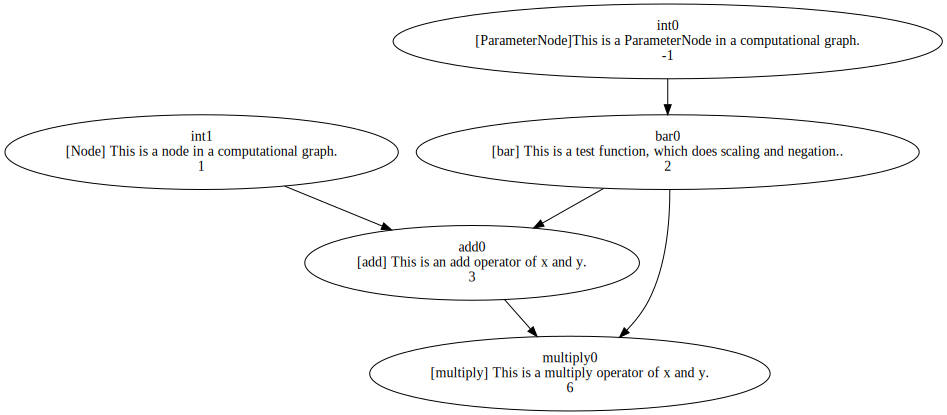

In [1]:
# Simple debugging example
import autogen
from autogen.trace import trace, trace_op
from autogen.trace.nodes import ParameterNode
from autogen.trace.propagators import FunctionPropagator
from autogen.trace.utils import get_name
from autogen.trace.optimizers import FunctionOptimizer


@trace_op()
def bar(x):
    "This is a test function, which does scaling and negation."
    y = x * 2
    return -y


def foo(x):
    y = x + 1
    return x * y


def user(x):
    if x < 100:
        return "The number needs be larger."
    else:
        return "Success."


# Test function propagate
config_list = autogen.config_list_from_json("OAI_CONFIG_LIST")

x = ParameterNode(-1)
optimizer = FunctionOptimizer([x], config_list=config_list)
visualize = True


output = foo(bar(x))
feedback = user(output.data)
optimizer.zero_feedback()
output.backward(feedback, propagator=optimizer.propagator, visualize=visualize)

In [2]:
summary = optimizer.propagator.aggregate(x.feedback)

# summary = propagator.summarize(x)

print("Graph:")
for k, v in sorted(summary.graph):
    print("  ", v)

print("Function definitions:")
for k, v in summary.documentation.items():
    print("  ", v)

print("Others:")
for k, v in summary.others.items():
    print("  ", f"{k}={v}")

print("Output")
for k, v in summary.output.items():
    print("  ", f"{k}={v}")

print("User feedback")
print("  ", summary.user_feedback)

print("Variable")
print("  ", f"{get_name(x)}={x.data}")

Graph:
   bar0 = bar(int0)
   add0 = add(bar0, int1)
   multiply0 = multiply(bar0, add0)
Function definitions:
   [multiply] This is a multiply operator of x and y.
   [add] This is an add operator of x and y.
   [bar] This is a test function, which does scaling and negation..
Others:
   add0=3
   bar0=2
Output
   multiply0=6
User feedback
   The number needs be larger.
Variable
   int0=-1


In [3]:
optimizer.step(verbose=True)

Prompt
 
You're tasked debug and solve a coding/algorithm problem. You will see the code, the documentation of each function used in the code, and the feedback about the code's execution result. Your goal is to improve the code's output based on the feedback by changing variables used in the code.

Specifically, a problem will be composed of the following parts:
- #Code: the code whose results you need to improve.
- #Documentation: the documentation of each function used in the code.
- #Variables: the values of the variables that you need to change.
- #Outputs: the result of the code.
- #Others: the values of other inputs to the code, or intermediate values created through the code.
- #Feedback: the feedback about the code's execution result.

You need to change the values of the variables in #Variables to improve the code's output in accordance to #Feedback. The explaination in #Documentation might be incomplete and just contain high-level description of each function. You can use the

NotImplementedError: 